In [1]:
%cd ..

d:\Projects\Github\UNet Diffusion


## Numeric names for images in a folder

In [2]:
# folder = "data/CelebA-HQ/images_512/custom/images/"

# start_number = 30000

# # List all files in the folder and sort them
# files = sorted(os.listdir(folder))

# # Rename each file
# for index, filename in enumerate(files):
#     old_path = os.path.join(folder, filename)
#     # Get the file extension
#     ext = os.path.splitext(filename)[1]
#     new_filename = f"{start_number + index}{ext}"
#     new_path = os.path.join(folder, new_filename)
#     os.rename(old_path, new_path)

# print("Renaming complete.")

## Dataset

In [3]:
import os
import csv
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
from omegaconf import OmegaConf

In [4]:
config = OmegaConf.load('configs/train_config_256.yaml')
data_config = config.data
print(OmegaConf.to_yaml(data_config))

path: data/CelebA-HQ/images_512/
parquet_path: /dbfs/mnt/ds-space/Hitesh/Datasets/CelebA-HQ/parquet_files/CelebA-HQ.parquet
image_size: 256
normalize: true
caption_path: data/CelebA-HQ/captions.csv



### Dataset Class

In [5]:
img_dir =data_config.path

valid_ext = ['png', 'jpg', 'jpeg', 'webp']
img_names = sorted([
    os.path.relpath(os.path.join(root, f), img_dir)
    for root, _, files in os.walk(img_dir)
    for f in files
    if os.path.splitext(f)[1][1:].lower() in valid_ext
], key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

img_names

['0.jpg',
 '1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg',
 '20.jpg',
 '21.jpg',
 '22.jpg',
 '23.jpg',
 '24.jpg',
 '25.jpg',
 '26.jpg',
 '27.jpg',
 '28.jpg',
 '29.jpg',
 '30.jpg',
 '31.jpg',
 '32.jpg',
 '33.jpg',
 '34.jpg',
 '35.jpg',
 '36.jpg',
 '37.jpg',
 '38.jpg',
 '39.jpg',
 '40.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg',
 '50.jpg',
 '51.jpg',
 '52.jpg',
 '53.jpg',
 '54.jpg',
 '55.jpg',
 '56.jpg',
 '57.jpg',
 '58.jpg',
 '59.jpg',
 '60.jpg',
 '61.jpg',
 '62.jpg',
 '63.jpg',
 '64.jpg',
 '65.jpg',
 '66.jpg',
 '67.jpg',
 '68.jpg',
 '69.jpg',
 '70.jpg',
 '71.jpg',
 '72.jpg',
 '73.jpg',
 '74.jpg',
 '75.jpg',
 '76.jpg',
 '77.jpg',
 '78.jpg',
 '79.jpg',
 '80.jpg',
 '81.jpg',
 '82.jpg',
 '83.jpg',
 '84.jpg',
 '85.jpg',
 '86.jpg',
 '87.jpg',
 '88.jpg',
 '89.jpg',
 '90.jpg',
 '91.jpg'

In [6]:
default_cap = 'A beautiful portrait of a person'
captions = {}
with open(data_config.caption_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        if len(row) < 3:
            continue
        file_name = os.path.basename(row[0])
        captions[file_name] = row[2].strip()
captions

{'0.jpg': 'Portrait of a young woman brown hair, wavy hair, arched eyebrows, bushy eyebrows, smiling, big lips, pointy nose, high cheekbones, bags under eyes, mouth slightly open, wearing lipstick, and heavy makeup.',
 '1.jpg': 'A young woman who is blond hair, wavy hair, arched eyebrows, smiling, mouth slightly open, wearing lipstick, and heavy makeup.',
 '2.jpg': 'Portrait of a young woman brown hair, wavy hair, smiling, big lips, high cheekbones, bags under eyes, wearing earrings, wearing lipstick, and without heavy makeup.',
 '3.jpg': 'A young woman who is black hair, wavy hair, bushy eyebrows, smiling, big nose, high cheekbones, mouth slightly open, wearing lipstick, and heavy makeup.',
 '4.jpg': 'This is a young woman brown hair, straight hair, big lips, mouth slightly open, wearing earrings, and without heavy makeup.',
 '5.jpg': 'A young woman who is blond hair, wavy hair, wearing earrings, wearing lipstick, wearing necklace, and without heavy makeup.',
 '6.jpg': 'Portrait of a 

In [7]:
T = transforms.Compose([
    transforms.Resize(data_config.image_size),
    transforms.CenterCrop(data_config.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# === ACCESS EXAMPLE IMAGES ===
idx = 3001
img_name = img_names[idx]

In [9]:
img_path = os.path.join(data_config.path, img_name)
img_path

'data/CelebA-HQ/images_512/3001.jpg'

In [10]:
img = Image.open(img_path).convert('RGB')
caption = captions.get(img_name, default_cap)

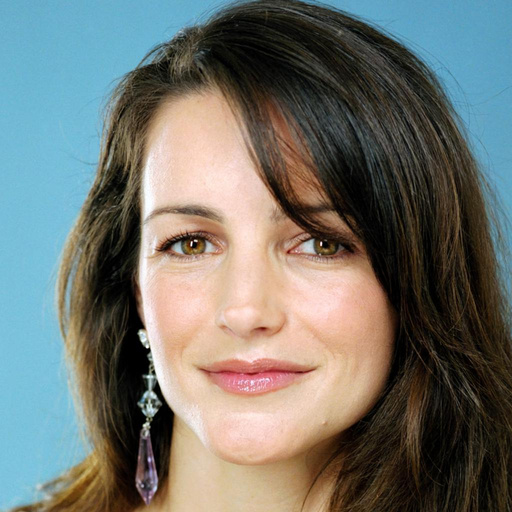

Filename: 3001.jpg
Caption: This is an older woman bangs, wavy hair, smiling, big lips, pointy nose, high cheekbones, wearing earrings, wearing lipstick, and heavy makeup.


In [11]:
display(img)
print("Filename:", img_name)
print("Caption:", caption)

In [12]:
img_tensor = T(img)
print("Tensor shape:", img_tensor.shape)

Tensor shape: torch.Size([3, 256, 256])


In [13]:
display(img_tensor)

tensor([[[-0.1922, -0.1843, -0.1843,  ..., -0.3098, -0.3020, -0.3020],
         [-0.2000, -0.2000, -0.1922,  ..., -0.3098, -0.3020, -0.3020],
         [-0.1843, -0.1765, -0.1843,  ..., -0.3255, -0.3176, -0.3255],
         ...,
         [ 0.0745,  0.1137,  0.1294,  ..., -0.6941, -0.6314, -0.7725],
         [ 0.0980,  0.1451,  0.1843,  ..., -0.7255, -0.5765, -0.7176],
         [ 0.1137,  0.1451,  0.2078,  ..., -0.7804, -0.6392, -0.6863]],

        [[ 0.3490,  0.3569,  0.3569,  ...,  0.2078,  0.2157,  0.2157],
         [ 0.3412,  0.3412,  0.3490,  ...,  0.2157,  0.2157,  0.2157],
         [ 0.3569,  0.3647,  0.3569,  ...,  0.2157,  0.2235,  0.2157],
         ...,
         [ 0.5294,  0.5373,  0.5451,  ..., -0.7333, -0.6549, -0.8275],
         [ 0.4902,  0.5137,  0.5216,  ..., -0.7569, -0.6000, -0.7725],
         [ 0.4275,  0.4588,  0.4667,  ..., -0.8118, -0.6706, -0.7412]],

        [[ 0.5765,  0.5843,  0.5843,  ...,  0.4588,  0.4667,  0.4667],
         [ 0.5686,  0.5686,  0.5765,  ...,  0

In [14]:
from utils.celeba_with_caption import CelebADataset, CelebAloader

In [15]:
dataset = CelebADataset(config=data_config)

In [16]:
dataloader, _ = CelebAloader(data_config=data_config, train_config=config.training)

In [17]:
print(f"Dataset size: {len(dataloader.dataset)} images, batch size: {dataloader.batch_size}")

Dataset size: 153 images, batch size: 4


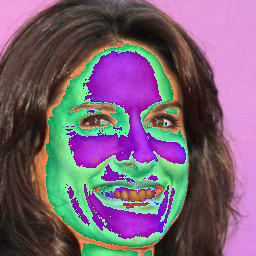

In [30]:
idx = 3

tensor_image = dataset.__getitem__(idx)['image']


import torch
from torchvision.transforms.functional import to_pil_image

to_pil_image(tensor_image)


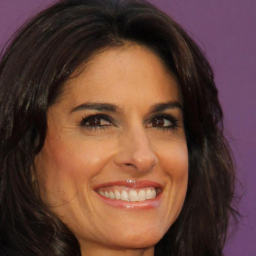

In [ ]:
import torchvision.transforms as transforms

# Create the denormalization transform
denorm = transforms.Normalize(
    mean=[-1, -1, -1],  # = -mean / std = -0.5 / 0.5
    std=[2, 2, 2]       # = 1 / std = 1 / 0.5
)
denorm_img = denorm(tensor_image)

to_pil_image(denorm_img)
